In [129]:
import os

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [130]:
root_dir = '/home/jupyter/aws_mle/geological_similarity'

#Get all filenames in folder:
img_files = [os.path.join(path,name) for path, subdirs, files in os.walk(root_dir) for name in files]
print('dataser length = ', len(img_files))
print('First 5 files:', img_files[0:5])

dataser length =  29998
First 5 files: ['/home/jupyter/aws_mle/geological_similarity/gneiss/VCS3C.jpg', '/home/jupyter/aws_mle/geological_similarity/gneiss/1YJ5O.jpg', '/home/jupyter/aws_mle/geological_similarity/gneiss/MN1QU.jpg', '/home/jupyter/aws_mle/geological_similarity/gneiss/1DY10.jpg', '/home/jupyter/aws_mle/geological_similarity/gneiss/8IGYW.jpg']


In [131]:
# Dataset consist of 6 folders each containing 5k photographs
subfolders = [f.path for f in os.scandir(root_dir) if f.is_dir()]
for subfolder in subfolders:
    print(subfolder.split('/')[-1], ':', len(os.listdir(subfolder)), 'images')

gneiss : 5000 images
andesite : 5000 images
marble : 4998 images
quartzite : 5000 images
rhyolite : 5000 images
schist : 5000 images


## Preview The Images

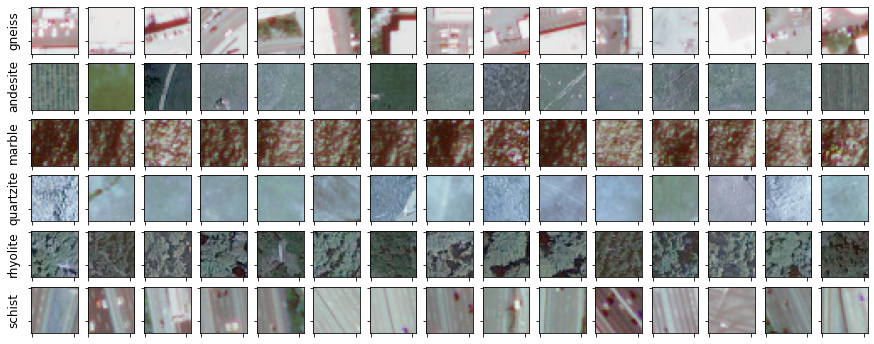

In [132]:
# Let's preview some randomly selected images of each class
n_show = 15

subfolders = [f.path for f in os.scandir(root_dir) if f.is_dir()]

fig, axes = plt.subplots(len(subfolders), n_show, figsize = (n_show,6))
# Preview images:
for row_idx, subfolder in enumerate(subfolders):    
    filenames = [f.path for f in os.scandir(subfolder)]   
    files_to_preview = random.sample(filenames, n_show)
    for col_idx, path in enumerate(files_to_preview):
        image = mpimg.imread(path)
        axes[row_idx, col_idx].imshow(image)
        axes[row_idx, col_idx].set_xticklabels([])
        axes[row_idx, col_idx].set_yticklabels([])

# Set labels:
for ax, row in zip(axes[:,0], subfolders):
    ax.set_ylabel(row.split('/')[-1], rotation=90, size='large')

plt.show()

## Create PyTorch Dataset from input data:

In [133]:
# Create Torch Dataset from input data:
class GeologicalDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        
        img_names_list = [os.path.join(path, name) for path, subdirs, files in os.walk(root_dir) for name in files]
        label_to_idx = {
            'andesite': 0,
            'gneiss': 1,
            'marble': 2,
            'quartzite': 3,
            'rhyolite': 4,
            'schist': 5
            }
        labels_list = [label_to_idx[os.path.join(path, name).split('/')[-2]]
                       for path, subdirs, files in os.walk(root_dir)
                       for name in files
                      ]
        
        img_names_train, img_names_test, labels_train, labels_test = train_test_split(
            img_names_list,
            labels_list,
            test_size=0.1,
            shuffle=True,
            random_state=42
        )

        if self.train == True:
            self.img_names = img_names_train
            self.labels = labels_train
        else:
            self.img_names = img_names_test
            self.labels = labels_test
            
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):        
        image = mpimg.imread(self.img_names[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

In [134]:
# Create transforms for train and test
    # All data transformed to Tensor and Normalized (for each channel) - see the parameters below
    # random horizontal and vertical flips are used for train
train_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    #transforms.RandomRotation(degrees=(0,360)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5080, 0.5196, 0.5195],
                         std=[0.1852, 0.1995, 0.2193])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5080, 0.5196, 0.5195],
                         std=[0.1852, 0.1995, 0.2193])
])

In [135]:
train_set = GeologicalDataset(root_dir = root_dir,transform=train_transform, train = True)
test_set = GeologicalDataset(root_dir = root_dir,transform=test_transform, train = False)

print('train_set:', len(train_set))
print('test_set:', len(test_set))

batch_size = 1024

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

train_set: 26998
test_set: 3000


## Create CNN Architecture

In [136]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.nn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(in_features=2304, out_features=512),
            nn.Dropout2d(0.25),
            nn.Linear(in_features=512, out_features=128),
            )

        self.linear = nn.Linear(in_features=128, out_features=6)
        
    def forward(self, x):
        embedding = self.nn(x)
        x = self.linear(embedding)
        return embedding, x
        
model = CNN()
print(model)

CNN(
  (nn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2304, out_features=512, bias=True)
    (10): Dropout2d(p=0.25, inplace=False)
    (11): Linear(in_features=512, out_features=128, bias=True)
  )
  (linear): Linear(in_features=128, out_features=6, bias=True)
)


## Instantiate The Model

In [137]:
model = CNN()

# model.load_state_dict(torch.load('model_state_dict.pth')) # load previously trained model

loss_func = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [138]:
%%time
# Train the model

writer = SummaryWriter()
                                  
num_epochs = 30

for epoch in range(num_epochs):
    
    train_accuracy_epoch=[]
    for train_batch_idx, (images, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        _, outputs = model(images)        
        predictions = torch.max(outputs, 1)[1]
        train_accuracy = accuracy_score(predictions, labels)
        train_accuracy_epoch.append(train_accuracy)
        loss = loss_func(outputs, labels)                
        loss.backward()        
        optimizer.step()
    
    avg_train_accuracy_epoch = np.mean(train_accuracy_epoch)
    print(avg_train_accuracy_epoch)
    writer.add_scalar("Train_accuracy", avg_train_accuracy_epoch, epoch)
          
    # At the end of epoch - evaluate test set accuracy
    test_accuracy_epoch=[]
    for test_batch_idx, (images, labels) in enumerate(test_loader):
        model.eval()       
        _, outputs = model(images)
        predictions = torch.max(outputs, 1)[1]
        test_accuracy = accuracy_score(predictions, labels)
        test_accuracy_epoch.append(test_accuracy)        
    
    avg_test_accuracy_epoch = np.mean(test_accuracy_epoch)
    writer.add_scalar("Test_accuracy", avg_test_accuracy_epoch, epoch)
    
    print('Epoch: ', epoch,
          '  Train accuracy:', round(avg_train_accuracy_epoch,4),
          '  Test accuracy:', round(avg_test_accuracy_epoch,4)
          )

writer.flush()

# run in the terminal to see the progress: 
# tensorboard --logdir runs

# Save the trained weights of the model
torch.save(model.state_dict(), 'model_state_dict.pth')

0.8189614821623094
Epoch:  0   Train accuracy: 0.819   Test accuracy: 0.9403
0.9341105602594574
Epoch:  1   Train accuracy: 0.9341   Test accuracy: 0.9474
0.9475886314121609
Epoch:  2   Train accuracy: 0.9476   Test accuracy: 0.9523
0.9572896551297286
Epoch:  3   Train accuracy: 0.9573   Test accuracy: 0.945
0.9613483177361855
Epoch:  4   Train accuracy: 0.9613   Test accuracy: 0.9643
0.9649006146019014
Epoch:  5   Train accuracy: 0.9649   Test accuracy: 0.9635
0.9656257349846504
Epoch:  6   Train accuracy: 0.9656   Test accuracy: 0.9783
0.9705886221281441
Epoch:  7   Train accuracy: 0.9706   Test accuracy: 0.9757
0.9726330399584077
Epoch:  8   Train accuracy: 0.9726   Test accuracy: 0.9732
0.9724504542978808
Epoch:  9   Train accuracy: 0.9725   Test accuracy: 0.9783
0.9750907899460289
Epoch:  10   Train accuracy: 0.9751   Test accuracy: 0.9824
0.9746757170355516
Epoch:  11   Train accuracy: 0.9747   Test accuracy: 0.9804
0.9770706064938601
Epoch:  12   Train accuracy: 0.9771   Test ac

In [139]:
def get_embedding(file, model):
    image = mpimg.imread(file)
    image = test_transform(image)
    image = image.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        emb, _ = model(image)
    return emb.numpy()

In [140]:
%%time
image_embeddings = np.zeros((len(img_files), 128))
for idx, file in enumerate(img_files):
    image_embeddings[idx] = get_embedding(file,model=model)
print(image_embeddings.shape)

(29998, 128)
CPU times: user 2min 23s, sys: 824 ms, total: 2min 24s
Wall time: 36.1 s


/home/jupyter/aws_mle/geological_similarity/schist/R6RLA.jpg


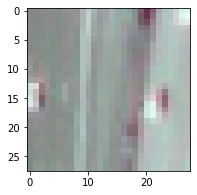

In [141]:
# Select random image from test
random_file = random.choice(img_files)

# Get the embedding for this image
emb = get_embedding(random_file, model=model)

print(random_file)
plt.rcParams["figure.figsize"] = (3,3)
image = mpimg.imread(random_file)
plt.imshow(image)
plt.show()

In [142]:
random_file = random.choice(img_files)

# Get the embedding for this image
emb = get_embedding_gcs(random_file, fs, model=model)

print(random_file)
plt.rcParams["figure.figsize"] = (3,3)
with fs.open(random_file) as f:
    image = mpimg.imread(f,0)
plt.imshow(image)
plt.show()

OSError: Forbidden: https://www.googleapis.com/storage/v1/b/home/o/jupyter%2Faws_mle%2Fgeological_similarity%2Fquartzite%2FW1OEE.jpg
The project to be billed is associated with an absent billing account.

In [ ]:
similarities = cosine_similarity(emb, image_embeddings)

In [ ]:
K=7
ids = np.flip(similarities.argsort()[0])[0:K]

for index in ids:
    image = img_files[index]
    image = mpimg.imread(image)
    plt.imshow(image)
    plt.show()